In [1]:
from sklearn.datasets import make_friedman1
import numpy as np
import statistics
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from tabulate import tabulate

from package import gpr
from package import io
from package import rf
from package import testhelper as th

from sklearn.gaussian_process.kernels import (Matern, ConstantKernel, WhiteKernel, RBF)

In [2]:
# define training data size
training_num = 1000

# x-values: all uniformly distributed between 0 and 1
x0_train=np.random.rand(training_num)*0.2
x1_train=np.random.rand(training_num)*0.2
x2_train=np.random.rand(training_num)*0.2
x3_train=np.random.rand(training_num)*0.2
x4_train=np.random.rand(training_num)*0.2

X_train = [[x0_train[i], x1_train[i], x2_train[i], x3_train[i], x4_train[i]] for i in range(0,training_num)]

# y-value with friedman function
y_train = 10*np.sin(np.pi*x0_train*x1_train) + 20*(x2_train - 0.5)**2 + 10*x3_train + 5*x4_train

In [3]:
# Define standard deviation of training data
standard_deviation = np.std(y_train)

# Define factor for scaling RF predicted errors
rf_slope = 0.32

In [4]:
# Train GPR
GPR = gpr.GPR()
GPR.train_synth(X_train, y_train, std=standard_deviation, kernelchoice=1, userkernel=ConstantKernel()*RBF(length_scale=[1.0 for i in range(0,len(X_train[0]))]), optimizer_restarts=30)

# Train RF
RF = rf.RF()
RF.train_synth(X_train, y_train, std=standard_deviation)

/Users/glennpalmer/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [5]:
# define test data size
test_num = 1000

# state which variable will be varied
k = 4

# x-values: add or remove the *0.5 for each one
x0_test=np.random.rand(test_num)*0.2
x1_test=np.random.rand(test_num)*0.2
x2_test=np.random.rand(test_num)*0.2
x3_test=np.random.rand(test_num)*0.2
x4_test=np.random.rand(test_num)

X_test = [[x0_test[i], x1_test[i], x2_test[i], x3_test[i], x4_test[i]] for i in range(0,test_num)]

# y-value with friedman function
y_test = 10*np.sin(np.pi*x0_test*x1_test) + 20*(x2_test - 0.5)**2 + 10*x3_test + 5*x4_test

In [6]:
def test2(test_data):
    # Define GPR and RF errors
    GPR_pred, GPR_errors = GPR.predict(test_data, True)
    RF_pred, RF_errors = RF.predict(test_data, True)
    RF_errors = rf_slope * RF_errors
    GPR_res = (y_test-GPR_pred)/standard_deviation
    RF_res = (y_test-RF_pred)/standard_deviation
    predictions = [th.predictdomain(GPR_errors[i], RF_errors[i]) for i in range(0, len(test_data))]
    results = [(predictions[i], GPR_errors[i], GPR_res[i], RF_errors[i], RF_res[i], x0_test[i], x1_test[i], x2_test[i], x3_test[i], x4_test[i]) for i in range(0, len(test_data))]
    results_print = [(predictions[i], GPR_errors[i], RF_errors[i], results[i][5+k]) for i in range(0, len(test_data))]
    #print(tabulate(results_print, headers=["In domain?", "GPR predicted error", str(rf_slope)+"*RF predicted error", "x"+str(k)+"_test value"]))
    return results

In [7]:
results = test2(X_test)

/Users/glennpalmer/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


# Letting x_k run from 0 to 5:

In [8]:
in_domain = []
out_domain = []
for i in range(0,test_num):
    if results[i][0]==0:
        out_domain.append(results[i][5+k])
    else:
        in_domain.append(results[i][5+k])

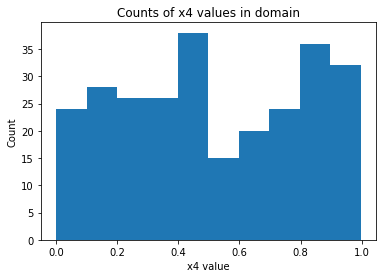

In [9]:
plt.xlabel("x" + str(k) + " value")
plt.ylabel("Count")
plt.title("Counts of x" + str(k) + " values in domain")
plt.hist(in_domain);

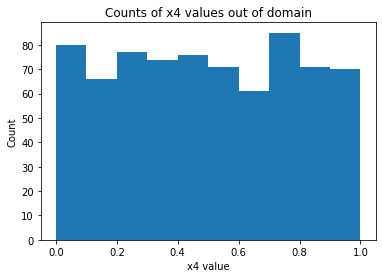

In [10]:
plt.xlabel("x" + str(k) + " value")
plt.ylabel("Count")
plt.title("Counts of x" + str(k) + " values out of domain")
plt.hist(out_domain);

In [11]:
bins = np.linspace(0, 1, 50, endpoint=False)
digitized_in = np.digitize(in_domain, bins)
digitized_out = np.digitize(out_domain, bins)

In [12]:
digitized_in = digitized_in.tolist()
digitized_out = digitized_out.tolist()

frac = []
for i in range(1,51):
    frac_in = (digitized_in.count(i)*1.0/(digitized_in.count(i)+digitized_out.count(i)))
    frac.append(frac_in)

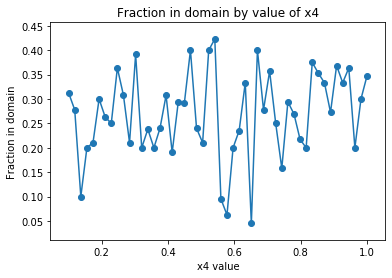

In [13]:
x = np.linspace(0.1,1,50)
y = frac

plt.xlabel("x" + str(k) + " value")
plt.ylabel("Fraction in domain")
plt.title("Fraction in domain by value of x" + str(k))

plt.scatter(x,y);
plt.plot(x,y);

In [14]:
GPR.printgprinfo(X_test,y_test)

316**2 * RBF(length_scale=121)
4654.844360503459
0.9999770809925662


In [15]:
in_domain_rfres_over_predicted = []
out_domain_rfres_over_predicted = []
for i in range(0,len(results)):
    if results[i][0]==0:
        out_domain_rfres_over_predicted.append(results[i][4]/results[i][3])
    else:
        in_domain_rfres_over_predicted.append(results[i][4]/results[i][3])

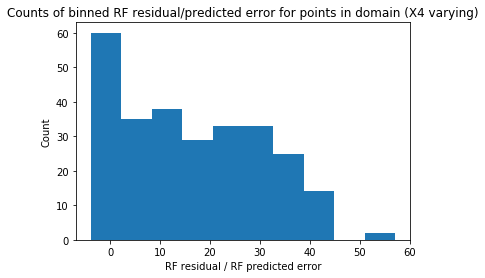

In [16]:
plt.xlabel("RF residual / RF predicted error")
plt.ylabel("Count")
plt.title("Counts of binned RF residual/predicted error for points in domain (X" + str(k) + " varying)")
plt.hist(in_domain_rfres_over_predicted);

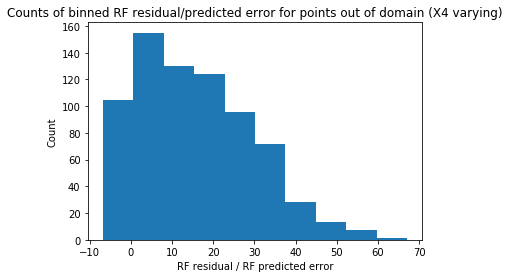

In [17]:
plt.xlabel("RF residual / RF predicted error")
plt.ylabel("Count")
plt.title("Counts of binned RF residual/predicted error for points out of domain (X" + str(k) + " varying)")
plt.hist(out_domain_rfres_over_predicted);

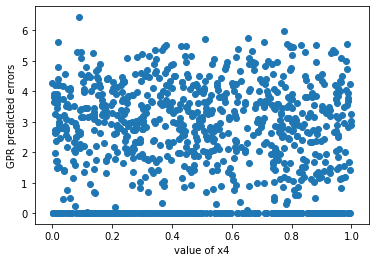

In [18]:
plt.ylabel("GPR predicted errors")
plt.xlabel("value of x" + str(k))
plt.scatter([results[i][5+k] for i in range(0,len(results))], [results[i][1] for i in range(0,len(results))]);

In [19]:
len(results)

1000

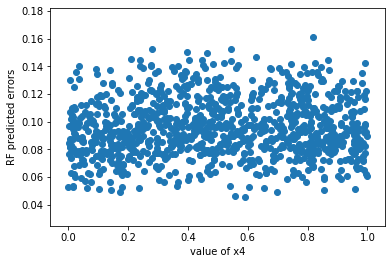

In [20]:
plt.ylabel("RF predicted errors")
plt.xlabel("value of x" + str(k))
plt.scatter([results[i][5+k] for i in range(0,len(results))], [results[i][3] for i in range(0,len(results))]);